In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_mm400 = pd.read_excel("./data/MM400A_HF2_1KApk_120420.xlsx")

In [3]:
df_nrwm = pd.read_excel("./data/NRWM_HF2_1KApk_120420.xlsx", sheet_name=1, header = [0,1])

In [4]:
def sq(x):
    return x*x

def findEndOfWeldCandidates(df, field, threshHi, threshLo):
    threshHi = threshHi
    threshLo = threshLo
    sqThreshHi = sq(threshHi)
    sqThreshLo = sq(threshLo)
    mss = 0
    mssHiList = []
    mssLoList = []
    for i in df.index:
        n=i+1
        mss = 1/n * (i*mss + sq(df.loc[i,field]))
        if sq(df.loc[n-1,field])  > mss * sq(threshHi) and sq(df.loc[n,field]) < mss * sq(threshHi):
            mssHiList.append((n,mss))
        if sq(df.loc[n-1,field])  > mss * sq(threshLo) and sq(df.loc[n,field]) < mss * sq(threshLo):
            mssLoList.append((n,mss))
        
    return mssHiList, mssLoList
                            

In [5]:
def plotResults(df, field, timeField, mssHiList, mssLoList, threshHi, threshLO, ymin, ymax):
    xHi = mssHiList[-1][0]
    yHi = np.sqrt(mssHiList[-1][1])
    xLo = mssLoList[-1][0]
    yLo = np.sqrt(mssLoList[-1][1])

    f, ax = plt.subplots(1,1,figsize=(15,10))
    ax.plot(df[timeField], df[field],"ro")
    ax.plot(df[timeField], df[field])
    ax.plot(df.loc[xHi,timeField],df.loc[xHi,field],"bs",markersize=10)
    ax.plot(df.loc[xLo,timeField],df.loc[xLo,field],"gs",markersize=10)
    #hlines(y, xmin, xmax, colors='k', linestyles='solid', label='', \*, data=None, \*\*kwargs)[source]
    ax.hlines([yHi,threshHi*yHi,0.1*yHi],0,12000)
    ax.vlines(df.loc[xHi,timeField],0,1.1)
    ax.vlines(df[timeField][xLo],0,0.6)
    ax.text(df.loc[xHi,timeField]+200,yHi+.02,"100% I_ISO_RMS" )
    ax.text(df.loc[xHi,timeField]+200,threshHi*yHi +.02,f"{threshHi:.0%} I_ISO_RMS" )
    ax.text(df.loc[xHi,timeField]+200,threshLo*yHi +.02,f"{threshLo:.0%} I_ISO_RMS" )
    ax.text(df.loc[xHi,timeField]+500,np.max(df[field]),f"ISO RMS = {yHi:.3} kA",fontsize=18 )
    ax.set_xlabel("Time (uSec)")
    ax.set_ylabel("Current (kA)")
    #ax.legend(["Samples","","Final 'first point below threshold'"])
    ax.grid()
    plt.show()

In [6]:
field_mm400 = "I kA"
field_nrwm = ('NRWM',  'Current KA')

timeField_mm400 = 'Time (uSec)'
timeField_nrwm = ('NRWM',     'Time uS')

threshHi = 0.9
threshLo = 0.1

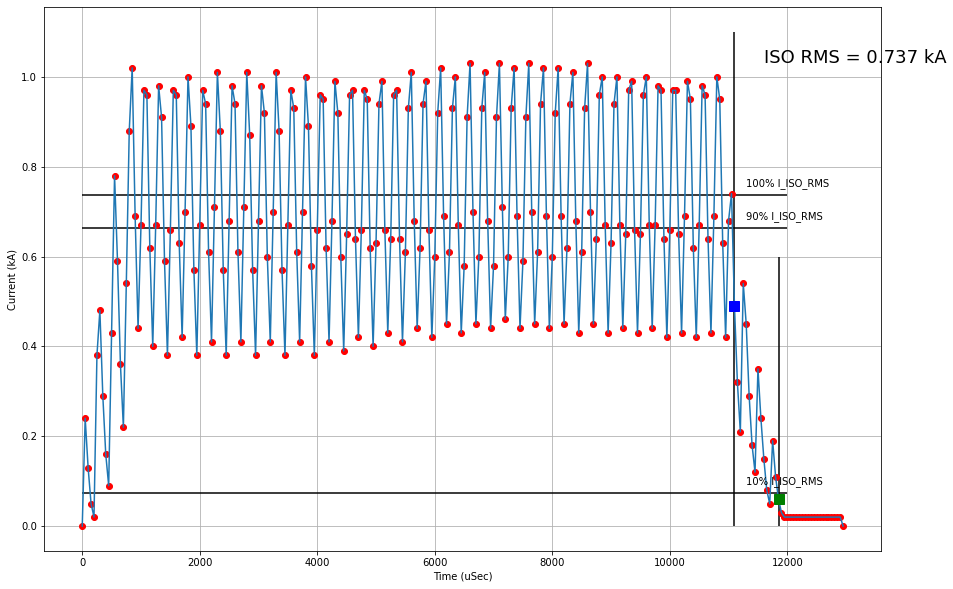

In [7]:
mssHiList, mssLoList = findEndOfWeldCandidates(df_mm400, field_mm400, threshHi, threshLo)
plotResults(df_mm400, field_mm400, timeField_mm400,  mssHiList, mssLoList, threshHi, threshLo, 0, 1.2)

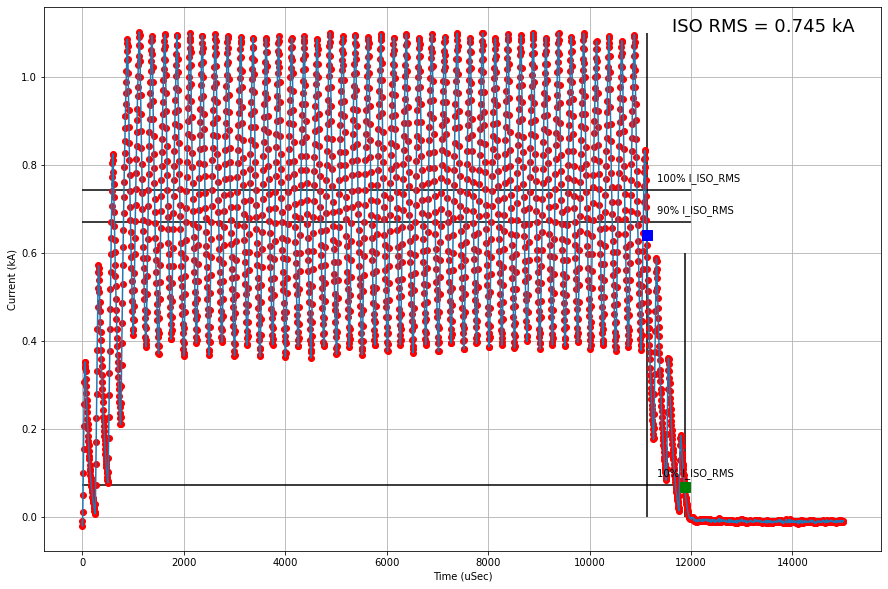

In [8]:
mssHiList, mssLoList = findEndOfWeldCandidates(df_nrwm, field_nrwm, threshHi, threshLo)
plotResults(df_nrwm, field_nrwm, timeField_nrwm, mssHiList, mssLoList, threshHi, threshLo, 0, 1.2)